# Corner Values Analysis

We will analyze entropy estimates and results of online tests based on measurements collected under various environmental conditions.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(context="notebook")
plt.style.use("ggplot")

In [2]:
dfs = []

for sheet_name in ["corner values config b1", "corner values config c1"]:
    df = pd.read_excel("../data/corner/corner_values.xlsx", header=1, sheet_name=sheet_name)
    df = df[~df.isna().all(axis=1)]
    df = df[~pd.to_numeric(df["T °C"], errors="coerce").isna()]
    df = df.infer_objects()
    df["min-E (NIST)"] = df["min-E (NIST)"].replace("nonIID", 0)
    df["min-E (NIST)"] = pd.to_numeric(df["min-E (NIST)"], errors="coerce")
    df["Board"] = df["Board"].fillna(method="ffill")
    df["config"] = sheet_name[-2:]
    dfs.append(df)

df = pd.concat(dfs)
df.rename({"alim V": "Power Supply [V]", "T °C": "Temp [°C]"}, axis=1, inplace=True)
df["Power [Condition]"] = (
    df.groupby(["Board"])["Power Supply [V]"].rank(method="dense").replace({1: "Low", 2: "Typical", 3: "Max"})
)
df.head()

,Board,Temp [°C],Power Supply [V],Mean,aVar,v from Pva,min-E (NIST),# contributors,All distances,config,Power [Condition]
0,SF2v11_10,24,1.14,140.32,1.10,1.46,0.989742,9,[58 11 36 11 47 11 47 11 47],b1,Low
1,SF2v11_10,24,1.14,140.31,1.13,1.46,0.993166,9,[11 47 11 47 58 11 36 11 47],b1,Low
2,SF2v11_10,24,1.14,140.32,1.14,1.46,0.994269,9,[58 11 36 11 47 11 47 11 47],b1,Low
3,SF2v11_10,24,1.14,140.31,1.14,1.46,0.992876,9,[11 47 58 11 36 11 47 11 47],b1,Low
4,SF2v11_10,24,1.14,140.31,1.12,1.46,0.991439,9,[11 36 11 47 11 47 11 47 58],b1,Low


## Alan Variance as Entropy Predictor

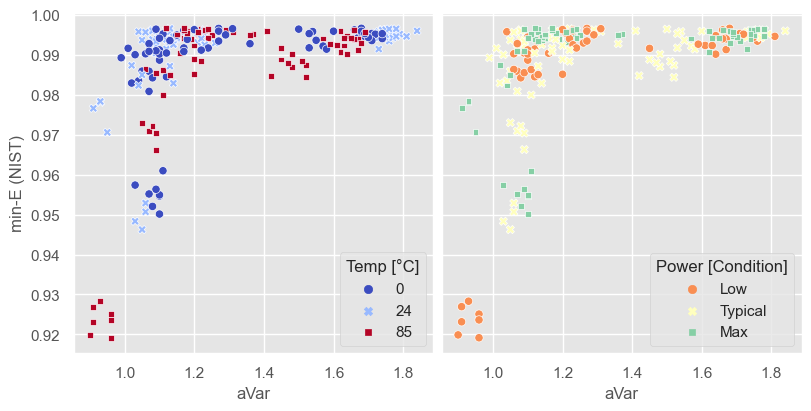

In [3]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True, constrained_layout=True)

markers = ["o", "x", "^", "+", "*", "8", "s", "p", "D", "V"]

mask = df["config"] == "b1"

ax = axs[0]
sns.scatterplot(
    data=df[mask], x="aVar", y="min-E (NIST)", hue="Temp [°C]", palette="coolwarm", style="Temp [°C]", ax=ax
)

ax = axs[1]

sns.scatterplot(
    data=df[mask],
    x="aVar",
    y="min-E (NIST)",
    hue="Power [Condition]",
    palette="Spectral",
    style="Power [Condition]",
    ax=ax,
)

fig.savefig("corner_values_aVar_vs_Ent.svg")

In [4]:
# NOTE: the anomaly cluster - it's Cyclon V
df[(df["aVar"] < 1.1) & (df["min-E (NIST)"] < 0.94) & (df["config"] == "b1")]

,Board,Temp [°C],Power Supply [V],Mean,aVar,v from Pva,min-E (NIST),# contributors,All distances,config,Power [Condition]
208,CVv11_11,85,1.07,248.20,0.96,1.29,0.925085,9,[47 47 47 47 47 47 47 72 94],b1,Low
209,CVv11_11,85,1.07,248.13,0.91,1.27,0.923158,9,[47 47 47 47 47 47 47 72 94],b1,Low
210,CVv11_11,85,1.07,248.17,0.93,1.24,0.928315,9,[72 47 47 47 47 47 47 47 94],b1,Low
211,CVv11_11,85,1.07,248.03,0.91,1.31,0.926946,10,[72 47 47 47 47 47 47 47 47 47],b1,Low
212,CVv11_11,85,1.07,248.12,0.90,1.26,0.919876,9,[47 47 47 47 47 47 47 94 72],b1,Low
213,CVv11_11,85,1.07,248.24,0.96,1.30,0.919159,9,[94 47 47 47 47 47 47 47 72],b1,Low
214,CVv11_11,85,1.07,248.22,0.96,1.27,0.923631,9,[47 47 47 47 47 47 47 72 94],b1,Low


## Predictive Power under Config-B

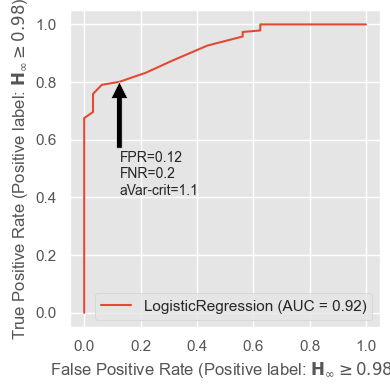

In [5]:
from sklearn import linear_model
from sklearn import metrics
import numpy as np

y = df["min-E (NIST)"] >= 0.98
y = y.replace({True: "$\mathbf{H}_{\infty}\geq 0.98$", False: "\mathbf{H}_{\infty} < 0.98"})
X = df[["aVar"]]

# mask = df['Temp [°C]']==24
mask = df["config"] == "b1"
X = X[mask]
y = y[mask]

model = linear_model.LogisticRegression()
model.fit(X, y)

fig, ax = plt.subplots(figsize=(4, 4))
disp = metrics.RocCurveDisplay.from_estimator(model, X, y, pos_label="$\mathbf{H}_{\infty}\geq 0.98$", ax=ax)

x_aVar = np.array(1.103)
y_pred = df[mask][["aVar"]] >= x_aVar
y_true = df[mask]["min-E (NIST)"] >= 0.98
((_, fpr), (fnr, _)) = metrics.confusion_matrix(y_true, y_pred, normalize="true")
ax.annotate(
    f"FPR={fpr.round(2)}\nFNR={fnr.round(2)}\naVar-crit={x_aVar.round(2)}",
    xy=(fpr, 1 - fnr),
    xycoords="data",
    xytext=(0.0, -50.0),
    textcoords="offset points",
    arrowprops=dict(facecolor="black"),
    horizontalalignment="left",
    verticalalignment="top",
)

plt.tight_layout()
fig.savefig("corner_values_Ent_pred_configb.svg")

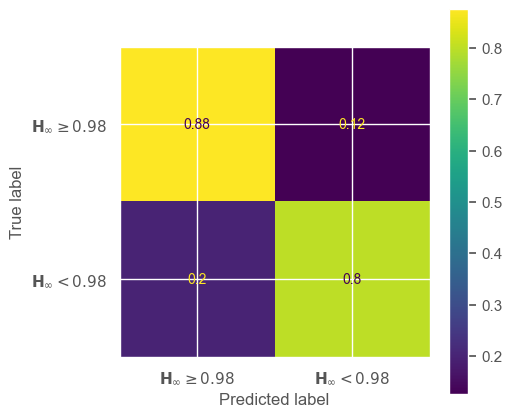

In [6]:
mask = df["config"] == "b1"
y_true = df[mask]["min-E (NIST)"] >= 0.98
y_pred = df[mask][["aVar"]] >= 1.103

fig, ax = plt.subplots(figsize=(5, 5))
disp = metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(y_true, y_pred, normalize="true"),
    display_labels=["$\mathbf{H}_{\infty}\geq 0.98$", "$\mathbf{H}_{\infty}< 0.98$"],
)
disp.plot(ax=ax)
fig.savefig("corner_values_Ent_confusion.svg", pad_inches=5)

# Predictive Power on All Data

We still see good results even with config C included. This proves the resilience.

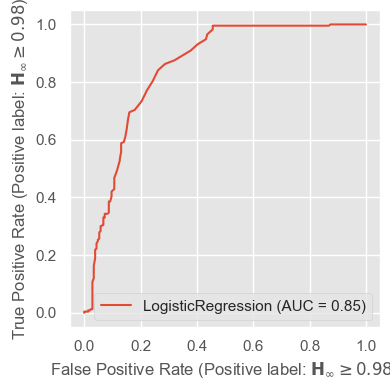

In [7]:
from sklearn import linear_model
from sklearn import metrics
import numpy as np

y = df["min-E (NIST)"] >= 0.98
y = y.replace({True: "$\mathbf{H}_{\infty}\geq 0.98$", False: "\mathbf{H}_{\infty} < 0.98"})
X = df[["aVar"]]

model = linear_model.LogisticRegression()
model.fit(X, y)

fig, ax = plt.subplots(figsize=(4, 4))
disp = metrics.RocCurveDisplay.from_estimator(model, X, y, pos_label="$\mathbf{H}_{\infty}\geq 0.98$", ax=ax)

plt.tight_layout()